num_states: 16
action from problem solver
State: [0.] - Action: 0 - Reward: 0 - Next State: 0 - Done: False
action from problem solver
State: [0.] - Action: 1 - Reward: 0 - Next State: 0 - Done: False
action from problem solver
State: [0.] - Action: 0 - Reward: 0 - Next State: 0 - Done: False
action from problem solver
State: [0.] - Action: 2 - Reward: 0 - Next State: 4 - Done: False
action from problem solver
State: [4.] - Action: 0 - Reward: 0 - Next State: 4 - Done: False
action from problem solver
State: [4.] - Action: 2 - Reward: -5 - Next State: 5 - Done: True
action from problem solver
State: [0.] - Action: 0 - Reward: 0 - Next State: 0 - Done: False
action from problem solver
State: [0.] - Action: 1 - Reward: 0 - Next State: 1 - Done: False
action from problem solver
State: [1.] - Action: 1 - Reward: 0 - Next State: 2 - Done: False
action from problem solver
State: [2.] - Action: 3 - Reward: 0 - Next State: 2 - Done: False
action from problem solver
State: [2.] - Action: 1 - Re

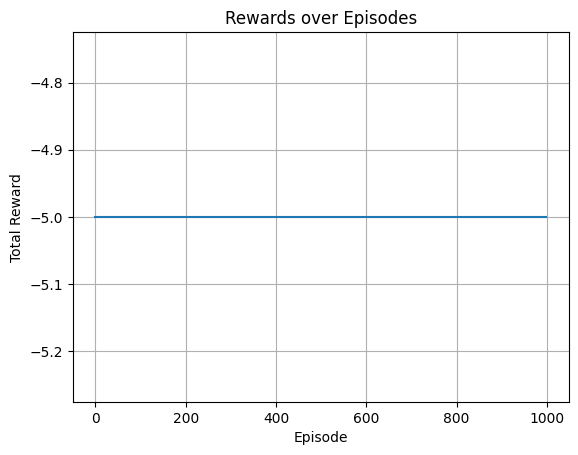

In [6]:
import numpy as np
import json
import gym
import matplotlib.pyplot as plt
import psutil
import pynvml
from collections import Counter
from gym.envs.registration import register
import torch.nn as nn
import torch.nn.functional as F

# Register the wrapper with a new environment ID
register(
    id='CustomRewardFrozenLake-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': True},
    max_episode_steps=100,
    reward_threshold=1,  # Adjust the reward threshold if needed
)

class CustomRewardFrozenLake(gym.Env):
    def __init__(self):
        self.env = gym.make("CustomRewardFrozenLake-v1")
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        if reward == 0 and not done:
            reward = 0
        elif reward == 0 and done:
            reward = -5
        elif reward == 1:
            reward = 1
        return state, reward, done, info

    def reset(self):
        # state = self.env.reset()
        # state_array = np.array([state], dtype=np.float32)  # Convert the state to a NumPy array
        # return state_array
        return self.env.reset()

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

import torch
import torch.nn as nn
import torch.optim as optim

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        # print(f"Policy Network Input size: {input_size}")
        self.fc1 = nn.Linear(input_size, 128)  # Adjust the hidden layer size as needed
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

class ProblemSolver:
    def __init__(self, num_states, num_actions, env):
        self.num_actions = num_actions
        self.num_states = num_states
        input_size = 1
        print(f"num_states: {num_states}")
        self.policy_network = PolicyNetwork(input_size, num_actions) 
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=0.01)

    def choose_action(self, state):
        # print(f"Third State Pass:{state}")
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert state to tensor and add a batch dimension
        # print("Input State Tensor:", state_tensor)  # Add this line to print the shape of the input tensor
        action_probs = self.policy_network(state_tensor)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def update_policy(self, rewards, log_probs):
        policy_losses = []
        for log_prob, reward in zip(log_probs, rewards):
            policy_losses.append(-log_prob * reward)
        loss = torch.stack(policy_losses).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, states, actions, rewards):
        log_probs = []
        for state, action in zip(states, actions):
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs = self.policy_network(state_tensor)
            log_probs.append(torch.log(action_probs.squeeze(0)[action]))
        
        self.update_policy(rewards, log_probs)


class Case:
    added_states = set()  # Class attribute to store states already added to the case base

    def __init__(self, problem, solution, trust_value=1):
        self.problem = np.array(problem)  # Convert problem to numpy array
        self.solution = solution
        self.trust_value = trust_value
    
    @staticmethod
    def sim_q(state1, state2):
        state1 = np.atleast_1d(state1)  # Ensure state1 is at least 1-dimensional
        state2 = np.atleast_1d(state2)  # Ensure state2 is at least 1-dimensional
        CNDMaxDist = 6  # Maximum distance between two nodes in the CND
        v = state1.size  # Total number of objects the agent can perceive
        DistQ = np.sum([Case.Dmin_phi(Objic, Objip) for Objic, Objip in zip(state1, state2)])
        similarity = (CNDMaxDist * v - DistQ) / (CNDMaxDist * v)
        return similarity

    @staticmethod
    def Dmin_phi(X1, X2):
        return np.max(np.abs(X1 - X2))
    

    @staticmethod
    def retrieve(state, case_base, threshold=0.2):
        similarities = {}
        for case in case_base:
            similarities[case] = Case.sim_q(state, case.problem)  # Compare state with the problem part of the case
        
        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
        
        if sorted_similarities:
            most_similar_case = sorted_similarities[0][0] if sorted_similarities[0][1] >= threshold else None
        else:
            most_similar_case = None
        
        return most_similar_case

    @staticmethod
    def reuse(c, temporary_case_base):
        temporary_case_base.append(c)
        # Store the new case from the problem solver
        # if c not in temporary_case_base:
            # temporary_case_base.append(c)
        
        # Check if there are similar cases in case_base
        # similar_cases = [case for case in case_base if np.array_equal(case.problem, c.problem)]
        # for similar_case in similar_cases:
            # temporary_case_base.append(similar_case)
            # if similar_case not in temporary_case_base:
            #     temporary_case_base.append(similar_case)

    @staticmethod
    def revise(case_base, temporary_case_base, successful_episodes):
        for case in temporary_case_base:
            if successful_episodes and case in case_base:
                case.trust_value += 0.1  # Increment trust value if the episode ended successfully and the case is in the case base
            elif not successful_episodes and case in case_base:
                case.trust_value -= 0.1  # Decrement trust value if the episode ended unsuccessfully and the case is in the case base
            case.trust_value = max(0, min(case.trust_value,1))  # Ensure trust value is within[0,1]

    @staticmethod
    def retain(case_base, temporary_case_base, successful_episodes, threshold=0):
        if successful_episodes:
            # Iterate through the temporary case base to find the last occurrence of each unique state
            for case in reversed(temporary_case_base):
                state = tuple(np.atleast_1d(case.problem))
                # Check if the state is already in the case base or has been added previously
                if state not in Case.added_states:
                    # Add the case to the case base if the state is new
                    case_base.append(case)
                    Case.added_states.add(state)
            
            # Filter case_base based on trust_value
            filtered_case_base = []
            for case in case_base:
                # print(f"trust value >= Threshold?: {case.trust_value} >= {threshold}?")
                if case.trust_value >= threshold:
                    # print(f"problem | trust value: {case.problem} | {case.trust_value}")
                    # print("case saved dong")
                    filtered_case_base.append(case)
                else:
                    # print(f"problem | trust value: {case.problem} | {case.trust_value}")
                    # print("case unsaved dong")
                    pass

            return filtered_case_base
        else:
            return case_base  # Return original case_base if episode is not successful

            
class QCBRL:
    def __init__(self, num_states, num_actions, env):
        self.num_actions = num_actions
        self.num_states = num_states
        self.env = env
        self.problem_solver = ProblemSolver(num_states, num_actions, env)
        self.case_base = []
        self.temporary_case_base = []

    def run(self, episodes=100, max_steps=100, alpha=0.1, gamma=0.9, epsilon=0.1, render=False):
        rewards = []
        memory_usage = []
        gpu_memory_usage = []
        successful_episodes = False
        num_successful_episodes = 0

        for episode in range(episodes):
            state = self.env.reset()
            state = np.array([state], dtype=np.float32)  # Convert the state to a NumPy array
            episode_reward = 0
            states = []
            actions = []
            episode_rewards = []

            # print("Reset State Value:", state)
            # print("Reset State Shape:", state.shape)

            for _ in range(max_steps):
                if render:
                    self.env.render()
                
                # print(f"First State Pass:{state}")
                action = self.take_action(state, epsilon)
                next_state, reward, done, _ = self.env.step(action)
                print(f"State: {state} - Action: {action} - Reward: {reward} - Next State: {next_state} - Done: {done}")

                states.append(state)
                actions.append(action)
                episode_rewards.append(reward)

                state = np.array([next_state], dtype=np.float32)  # Convert the next state to a NumPy array
                episode_reward += reward

                if done:
                    successful_episodes = reward > 0
                    break
                
            if successful_episodes:
                num_successful_episodes += 1

            rewards.append(episode_reward)
            self.problem_solver.train(states, actions, episode_rewards)
        
        success_rate = (num_successful_episodes / episodes) * 100
        return rewards, success_rate, memory_usage, gpu_memory_usage



    def take_action(self, state, epsilon):
        # print(f"Second State Pass:{state}")
        similar_solution = Case.retrieve(state, self.case_base)
        if similar_solution is not None:
            action = similar_solution.solution
            print("action from case base")
        else:
            action = self.problem_solver.choose_action(state)
            print("action from problem solver")
        
        # action = self.problem_solver.choose_action(state, epsilon)
        
        return action
    
    def save_case_base_temporary(self):
        filename = "case_base_temporary.json"
        case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else int(case.problem), 
                        "solution": int(case.solution), 
                        "trust_value": int(case.trust_value)} for case in self.temporary_case_base]
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)
        print("Temporary case base saved successfully.")

    def save_case_base(self):
        filename = "case_base.json"
        case_base_data = [{"problem": case.problem.tolist() if isinstance(case.problem, np.ndarray) else int(case.problem), 
                        "solution": int(case.solution), 
                        "trust_value": int(case.trust_value)} for case in self.case_base]
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

            print("Case base saved successfully.")  # Add this line to check if the case base is being saved
        
    def load_case_base(self):
        filename = "case_base.json"
        try:
            with open(filename, 'r') as file:
                case_base_data = json.load(file)
                self.case_base = [Case(np.array(case["problem"]), case["solution"], case["trust_value"]) for case in case_base_data]
                print("Case base loaded successfully.")  # Add this line to check if the case base is being loaded
        except FileNotFoundError:
            print("Case base file not found. Starting with an empty case base.")

    
    def display_success_rate(self, success_rate):
        print(f"Success rate: {success_rate}%")


    def plot_rewards(self, rewards):
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Rewards over Episodes')
        plt.grid(True)
        plt.show() 

    def plot_resources(self, memory_usage, gpu_memory_usage):
        plt.plot(memory_usage, label='Memory (%)')
        plt.plot(gpu_memory_usage, label='GPU Memory (MB)')
        plt.xlabel('Episode')
        plt.ylabel('Resource Usage')
        plt.title('Resource Usage over Episodes')
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == "__main__":
    # env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    # env = gym.make('FrozenLake-v1')
    env = CustomRewardFrozenLake()
    
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # print(num_actions)
    # print(num_states)
    agent = QCBRL(num_states, num_actions, env)
    rewards, success_rate, memory_usage, gpu_memory_usage = agent.run(episodes=1000, max_steps=1000, alpha=0.1, gamma=0.9, epsilon=0.1)

    agent.display_success_rate(success_rate)
    agent.plot_rewards(rewards)
    # agent.plot_resources(memory_usage, gpu_memory_usage)